In [1]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [ ]:
import holoviews as hv
import hvplot.polars  # noqa
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from polars import col

from src.data.database_manager import DatabaseManager
from src.log_config import configure_logging
from src.plots.averages_over_stimulus_seeds import (
    add_ci_to_averages,
    average_over_stimulus_seeds,
    calculate_crosscorr_matrix,
    plot_averages_with_ci_plt,
    plot_correlation_heatmap,
)

configure_logging(
    ignore_libs=("Comm", "bokeh", "tornado", "matplotlib"),
)

pl.Config.set_tbl_rows(12)  # for 12 seeds
hv.output(widget_location="bottom", size=150)

In [3]:
db = DatabaseManager()

In [4]:
with db:
    df = db.get_trials("Explore_Data", exclude_problematic=True)

df = df.rename({"rating": "pain_rating"})
df

trial_id,trial_number,participant_id,timestamp,temperature,pain_rating,eda_raw,eda_tonic,eda_phasic,eda_tonic_detrended,ppg_raw,heart_rate,ibi,pupil_l_raw,pupil_r_raw,pupil_r,pupil_l,pupil,brow_furrow,cheek_raise,mouth_open,upper_lip_raise,nose_wrinkle,normalized_timestamp,stimulus_seed,skin_patch,decreasing_intervals,major_decreasing_intervals,increasing_intervals,strictly_increasing_intervals,strictly_increasing_intervals_without_plateaus,plateau_intervals,prolonged_minima_intervals
u16,u8,u8,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u16,u8,u16,u16,u16,u16,u16,u16,u16
1,1,1,200180.9348,0.0,0.38375,19.652376,19.436877,0.215499,1.389781,1372.496197,75.75827,3.021361,4.784992,4.444289,4.450926,4.785598,4.618262,0.205826,0.00012,0.00039,0.000317,0.000665,0.0,870,1,0,0,1,1,1,0,0
1,1,1,200280.9348,0.000056,0.395091,19.793001,19.453226,0.339775,1.405727,1365.584792,75.95712,-4.283564,4.82506,4.452629,4.449446,4.789018,4.619232,0.192546,0.00012,0.000411,0.000309,0.000642,100.0,870,1,0,0,1,1,1,0,0
1,1,1,200380.9348,0.000241,0.406316,19.884253,19.466441,0.417812,1.418614,1356.423933,76.15928,-0.763131,4.835159,4.469986,4.446379,4.789661,4.61802,0.1817,0.000119,0.000432,0.000303,0.000625,200.0,870,1,0,0,1,1,1,0,0
1,1,1,200480.9348,0.000572,0.415328,20.012645,19.486828,0.525816,1.438493,1397.727216,76.585482,1.514833,4.842851,4.481221,4.449453,4.788254,4.618853,0.175569,0.000118,0.00045,0.000302,0.00062,300.0,870,1,0,0,1,1,1,0,0
1,1,1,200580.9348,0.001049,0.424044,20.094258,19.50245,0.591808,1.453722,1444.547187,77.051665,-12.188997,4.829974,4.489243,4.444739,4.789912,4.617325,0.172782,0.000117,0.00046,0.000302,0.000618,400.0,870,1,0,0,1,1,1,0,0
1,1,1,200680.9348,0.001676,0.435615,20.156349,19.518017,0.638333,1.468894,1419.597873,77.653838,46.059466,4.798762,4.477897,4.452002,4.787977,4.61999,0.170531,0.000115,0.00048,0.000304,0.000624,500.0,870,1,0,0,1,1,1,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
496,4,42,1.1405e6,0.031406,0.0,15.030559,15.008543,0.022016,-2.603602,1434.106413,62.353678,-1.19803,3.577106,3.476652,3.50111,3.600631,3.550871,0.015639,0.000177,0.139924,0.002577,0.002907,179500.0,806,3,2395,1437,0,0,0,0,0
496,4,42,1.1406e6,0.030945,0.0,15.025569,15.006031,0.019538,-2.606329,1412.519621,62.199718,-0.764415,3.548026,3.485169,3.49922,3.594389,3.546804,0.016379,0.000181,0.145722,0.002668,0.002891,179600.0,806,3,2395,1437,0,0,0,0,0


In [5]:
signals = [
    "temperature",
    "pain_rating",
    "brow_furrow",
    "cheek_raise",
    "mouth_open",
    "nose_wrinkle",
    "upper_lip_raise",
]


## Averaged trials over stimulus seeds with confidence intervals

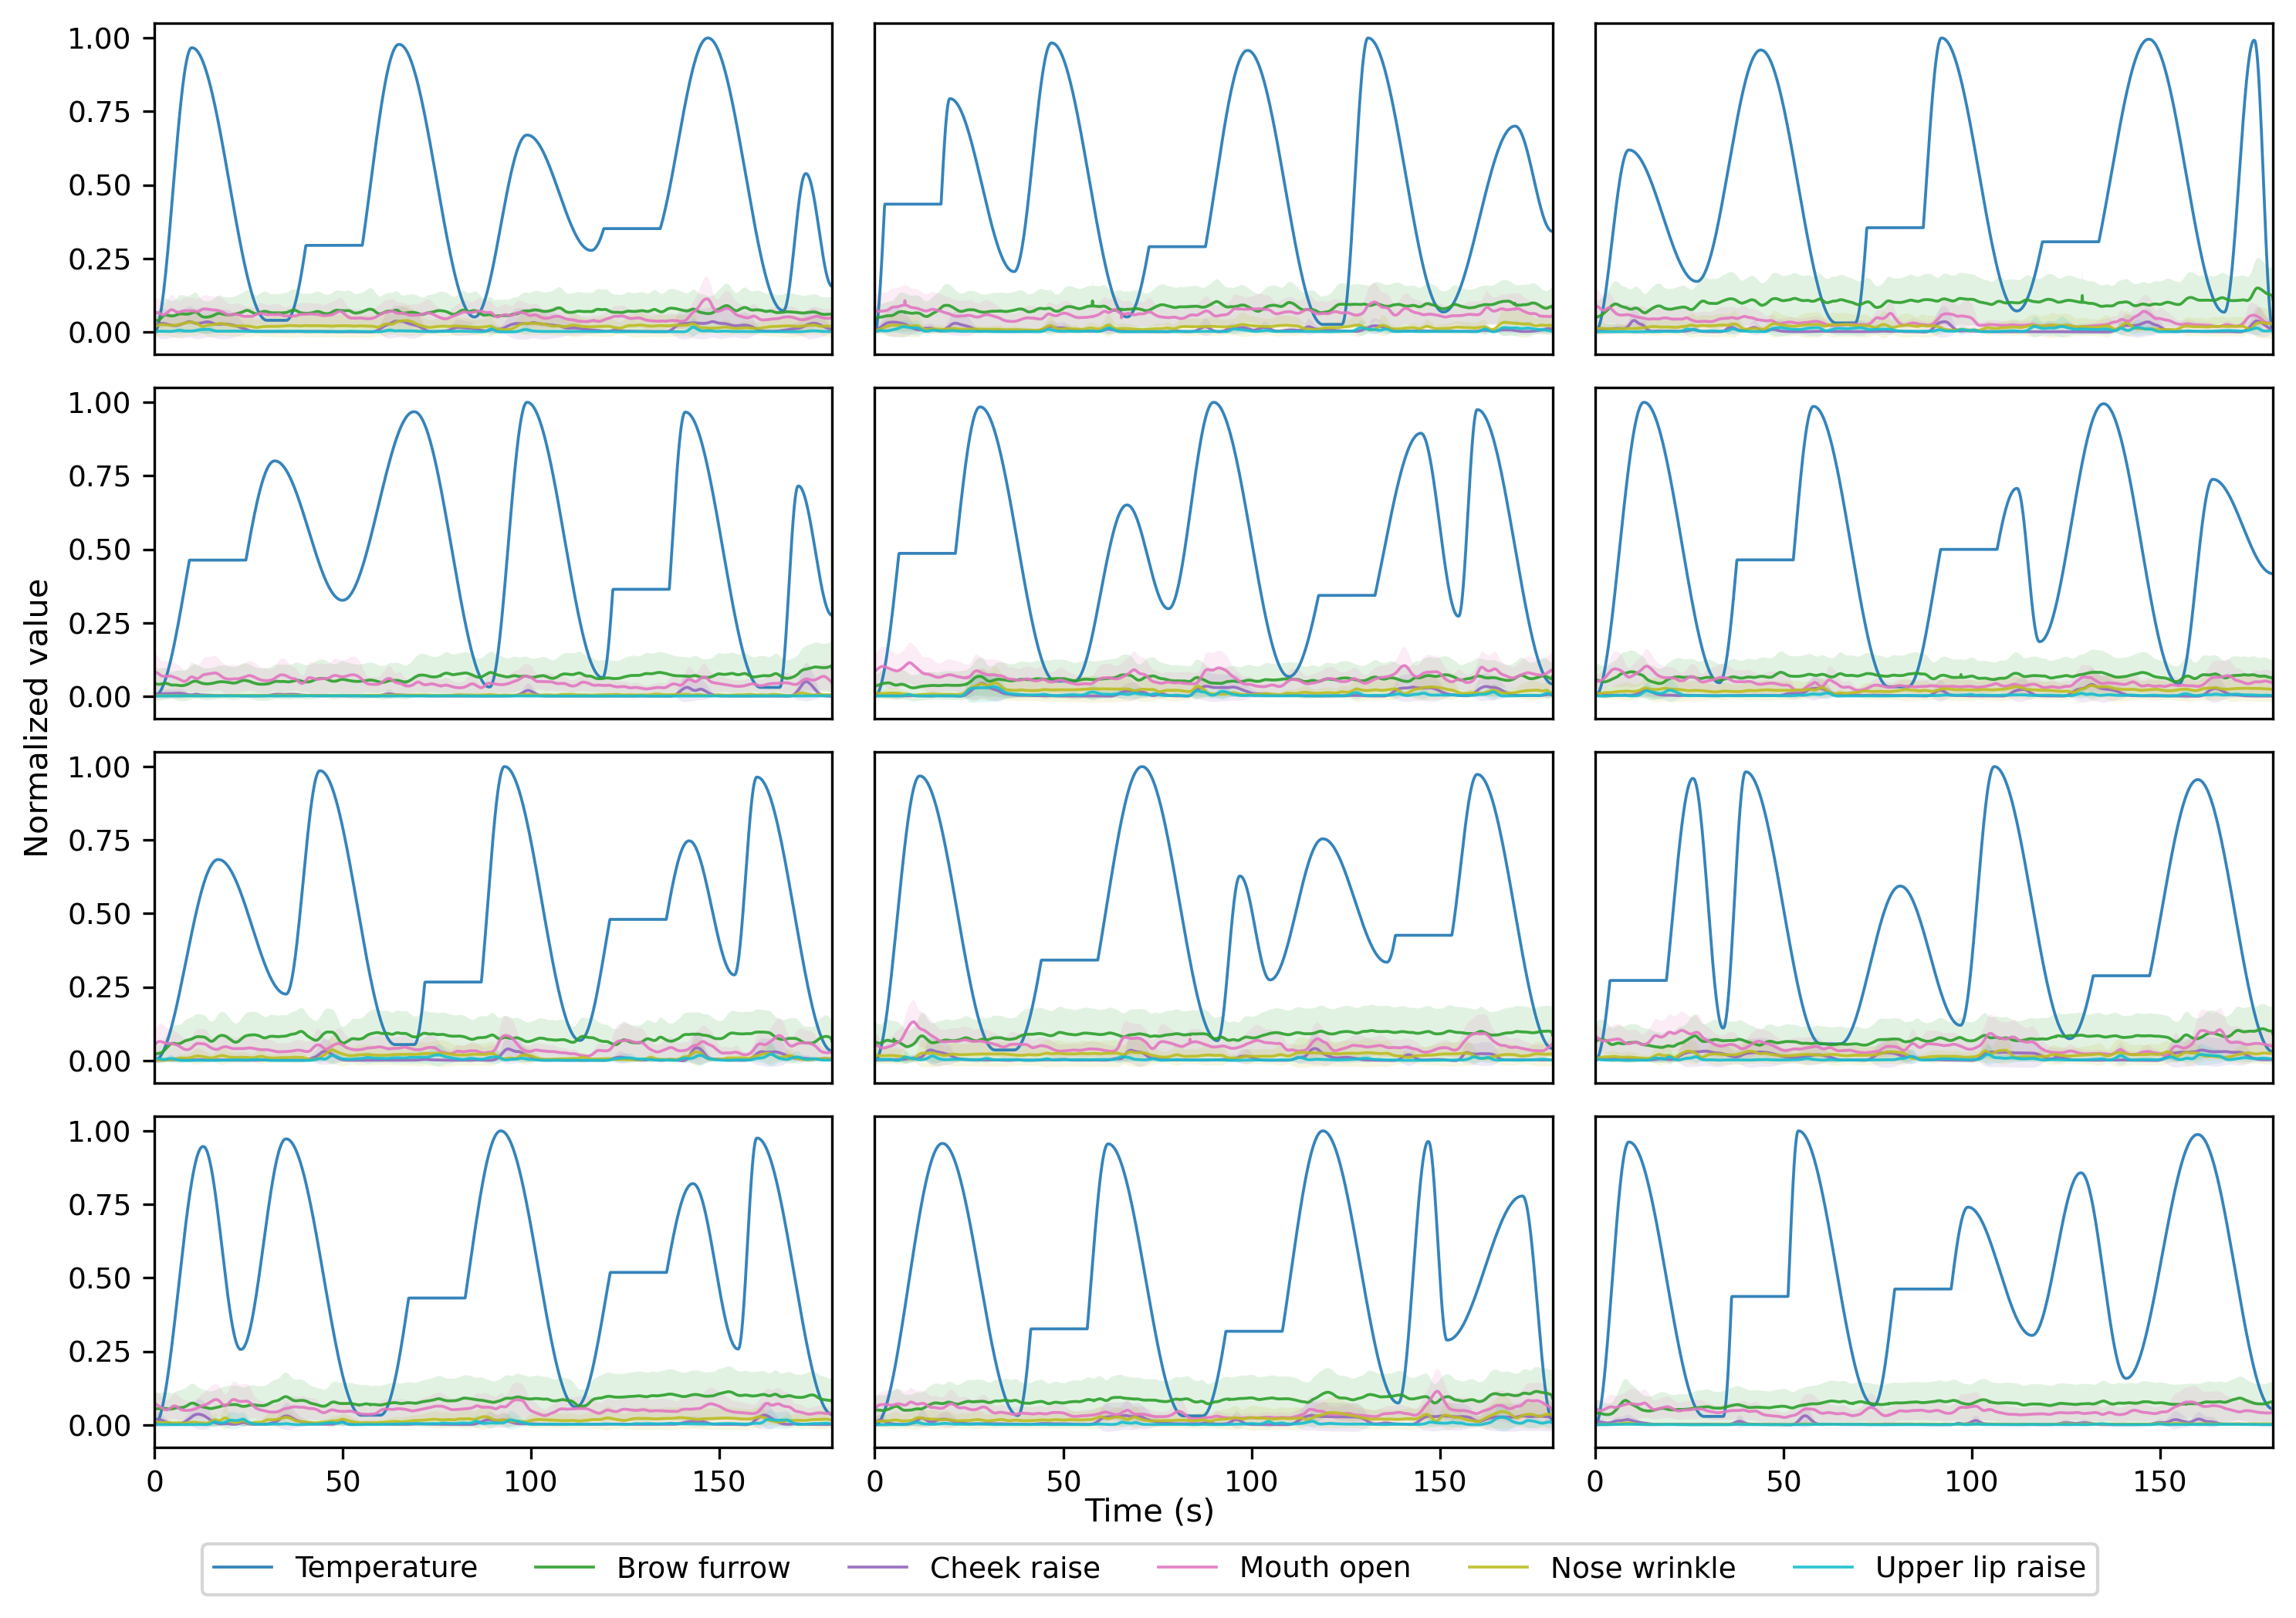

In [6]:
averages = average_over_stimulus_seeds(
    df,
    signals,
    scaling="min_max",
    bin_size=0.1,
)
averges_with_ci = add_ci_to_averages(
    averages,
    signals,
    confidence_level=0.95,
)
plots = plot_averages_with_ci_plt(
    averges_with_ci.drop("avg_pain_rating"),
    [s for s in signals if s != "pain_rating"],
    alpha=0.9,
)


In [7]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

plots.savefig(FIGURE_DIR / "averages_over_stimulus_seeds_face.png")

# Correlation matrix

In [7]:
# Remove first 20 seconds
# NOTE: important for the paper
averages = averages.filter(col("time_bin") >= 20)

In [9]:
averages

stimulus_seed,avg_temperature,avg_pain_rating,avg_brow_furrow,avg_cheek_raise,avg_mouth_open,avg_nose_wrinkle,avg_upper_lip_raise,std_temperature,std_pain_rating,std_brow_furrow,std_cheek_raise,std_mouth_open,std_nose_wrinkle,std_upper_lip_raise,sample_size,time_bin
u16,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,f64
133,0.500538,0.227467,0.058007,0.025637,0.058283,0.023705,0.002805,0.000826,0.224506,0.18791,0.146979,0.115905,0.115654,0.010515,37,20.0
133,0.493263,0.215004,0.058049,0.025458,0.058316,0.023504,0.00281,0.000839,0.218409,0.18792,0.145974,0.115124,0.115203,0.01062,37,20.1
133,0.485975,0.204909,0.058138,0.025189,0.058423,0.0232,0.002826,0.000835,0.215046,0.187982,0.144422,0.114487,0.114434,0.010821,37,20.2
133,0.478646,0.196032,0.058275,0.024921,0.058562,0.022887,0.002857,0.00087,0.211645,0.188118,0.142874,0.113943,0.113466,0.0111,37,20.3
133,0.471355,0.188876,0.05845,0.024615,0.058777,0.022548,0.002893,0.000873,0.207428,0.188331,0.141067,0.113592,0.112391,0.011412,37,20.4
133,0.464048,0.1846,0.058629,0.02428,0.059005,0.022201,0.002932,0.000873,0.204376,0.188618,0.139061,0.113345,0.111272,0.011747,37,20.5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
952,0.055794,0.045383,0.078023,0.001014,0.040738,0.002993,0.00086,0.000191,0.126091,0.223561,0.003521,0.096456,0.009055,0.002593,40,179.4
952,0.055265,0.042738,0.078312,0.001006,0.04097,0.003039,0.000861,0.00015,0.123876,0.223846,0.0035,0.097388,0.009238,0.0026,40,179.5


In [10]:
# Reorder signals for correlation matrix
signals = [
    "temperature",
    "pain_rating",
    "cheek_raise",
    "mouth_open",
    "upper_lip_raise",
    "nose_wrinkle",
    "brow_furrow",
]


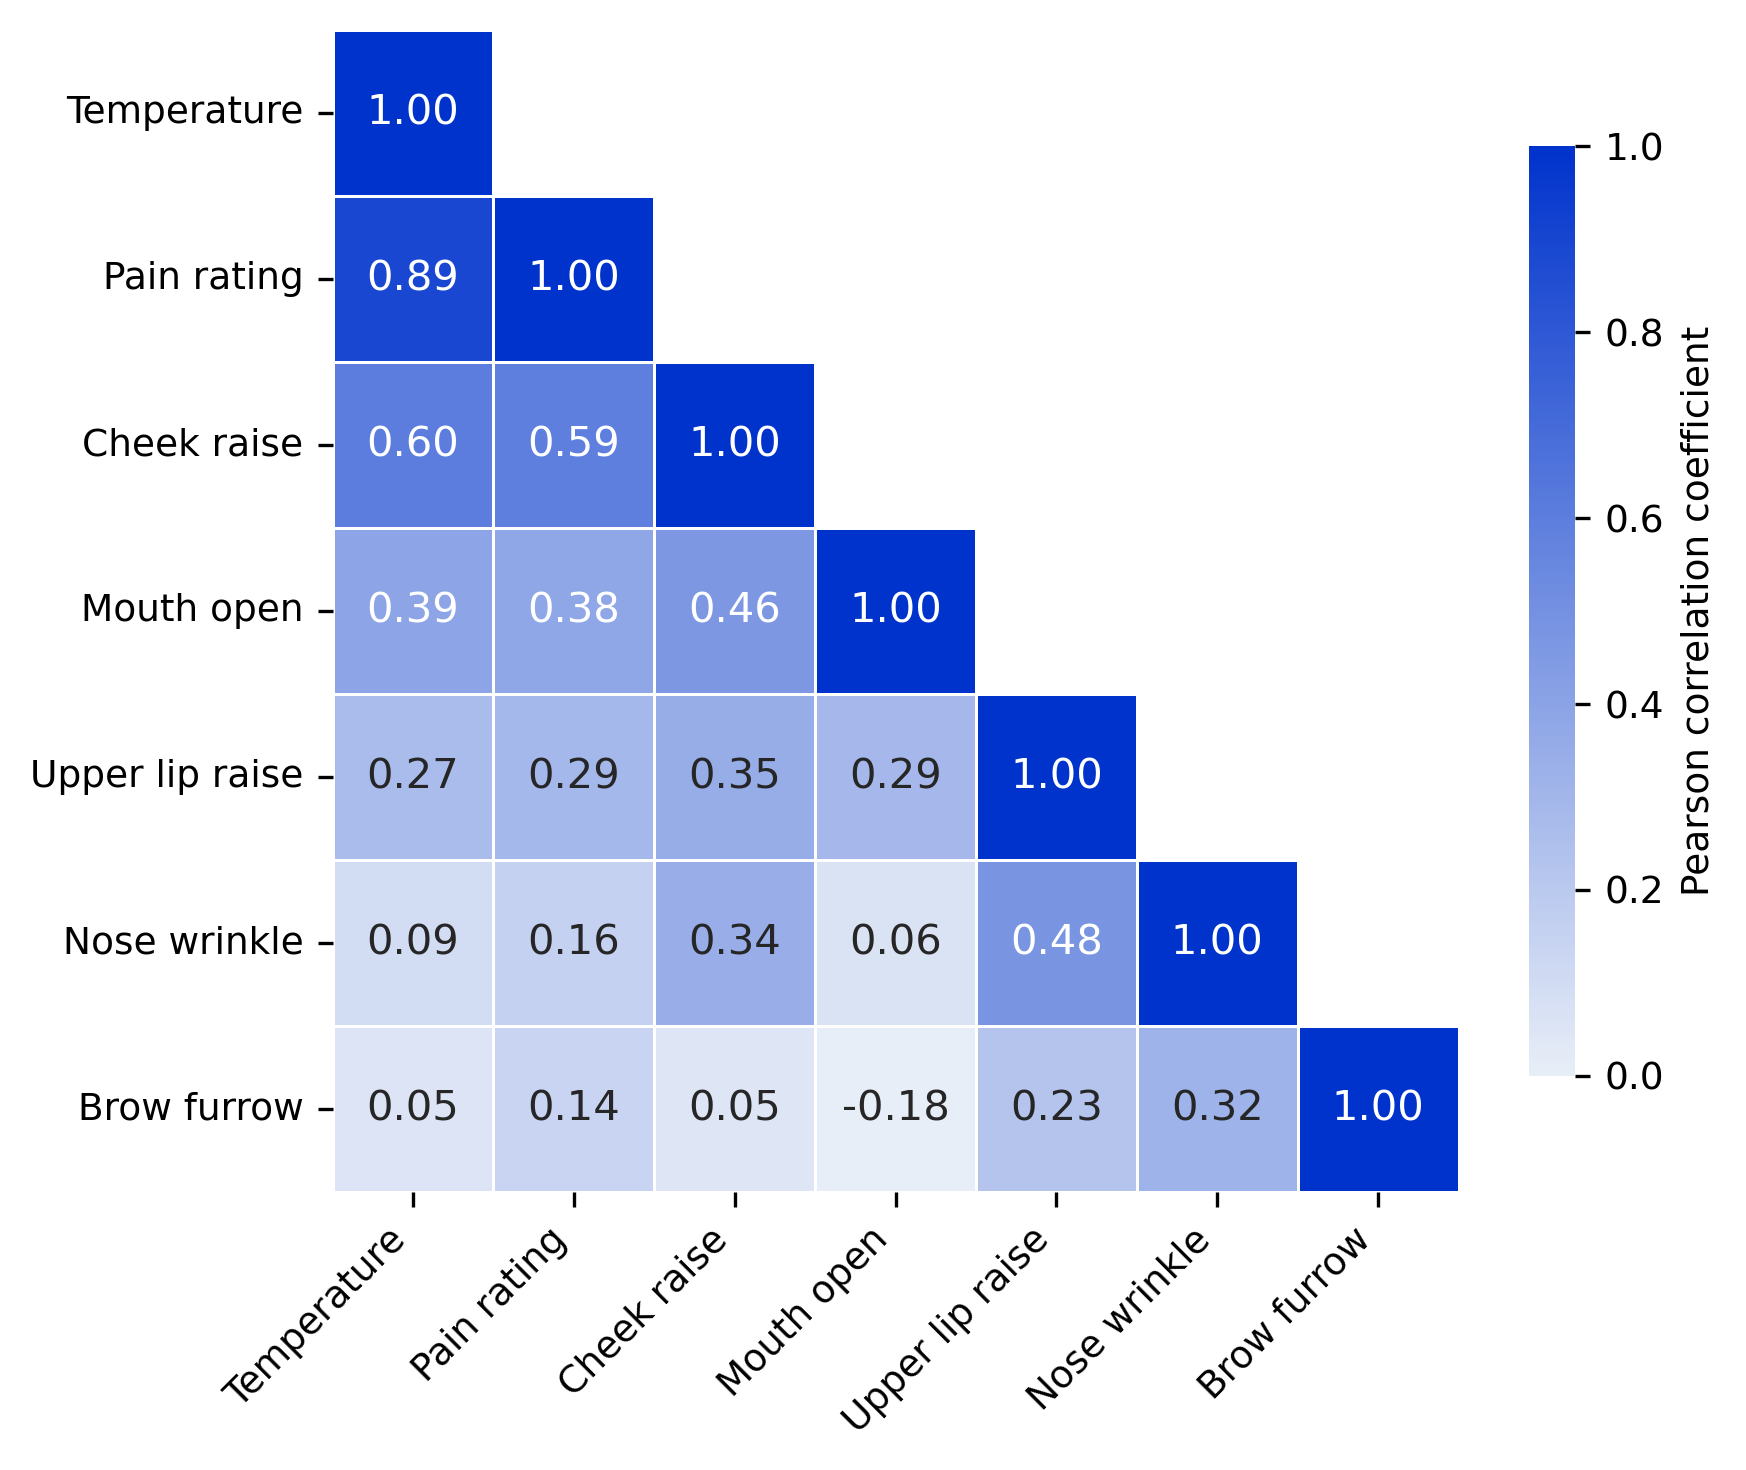

In [11]:
# without first 20 seconds
correlation_heatmap = plot_correlation_heatmap(averages, signals)

In [12]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))

correlation_heatmap.savefig(
    FIGURE_DIR / "correlation_matrix_face.png", dpi=300, bbox_inches="tight"
)

## Cross correlation lags of grand means

In [8]:
# Already calculated in the averages_over_stimuli_seeds notebook
signals.remove("temperature")
signals.remove("pain_rating")

In [30]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="temperature",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_face_results.json")
cross_corr_results

reference_signal,target_signal,mean_lag,std_lag
str,str,f64,f64
"""temperature""","""upper_lip_raise""",1.5,7.495554
"""temperature""","""nose_wrinkle""",1.433333,4.409334
"""temperature""","""mouth_open""",-0.558333,0.714677
"""temperature""","""cheek_raise""",-0.625,0.868068
"""temperature""","""brow_furrow""",-2.45,1.905912


In [36]:
cross_corr_results = calculate_crosscorr_matrix(
    averages,
    signals,
    reference_signal="pain_rating",
    fs=10,
)
cross_corr_results = cross_corr_results.drop("individual_lags", "stimulus_seeds")
cross_corr_results.write_json(FIGURE_DIR / "cross_corr_face_rating_results.json")
cross_corr_results

reference_signal,target_signal,mean_lag,std_lag
str,str,f64,f64
"""pain_rating""","""nose_wrinkle""",2.583333,4.191228
"""pain_rating""","""upper_lip_raise""",2.583333,7.520066
"""pain_rating""","""cheek_raise""",0.95,1.065755
"""pain_rating""","""mouth_open""",0.1,0.316228
"""pain_rating""","""brow_furrow""",-1.391667,2.085449
